# 1. Imports

In [1]:
from build_model import build_v2g_model, build_v2g_model_multinomial, evaluate_subset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import itertools
from sklearn.model_selection import cross_val_score

# 2. Model setup

In [2]:
input_variables = ['Q9','Q2','Q8_1','Q8_2']
target_variable = 'Q10_2'  # "I would be interested in installing V2G..."
csv_file = './data/survey_pre_processed_data.csv'

In [3]:
q10_2_categories = [
    "Strongly disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Strongly agree"
    ]

input_variables_names = [
    'How familiar are you with V2G?',
    'How many kilometres do you drive per year?',
    'Owns Solar Panels',
    'Owns Home battery',

]

# 3. Model run

In [6]:
model, X, y, X_test, y_test = build_v2g_model_multinomial(csv_file, input_variables, target_variable, do_normalize=True, test_split_ratio=0.0)

Training accuracy: 0.43837638376383764


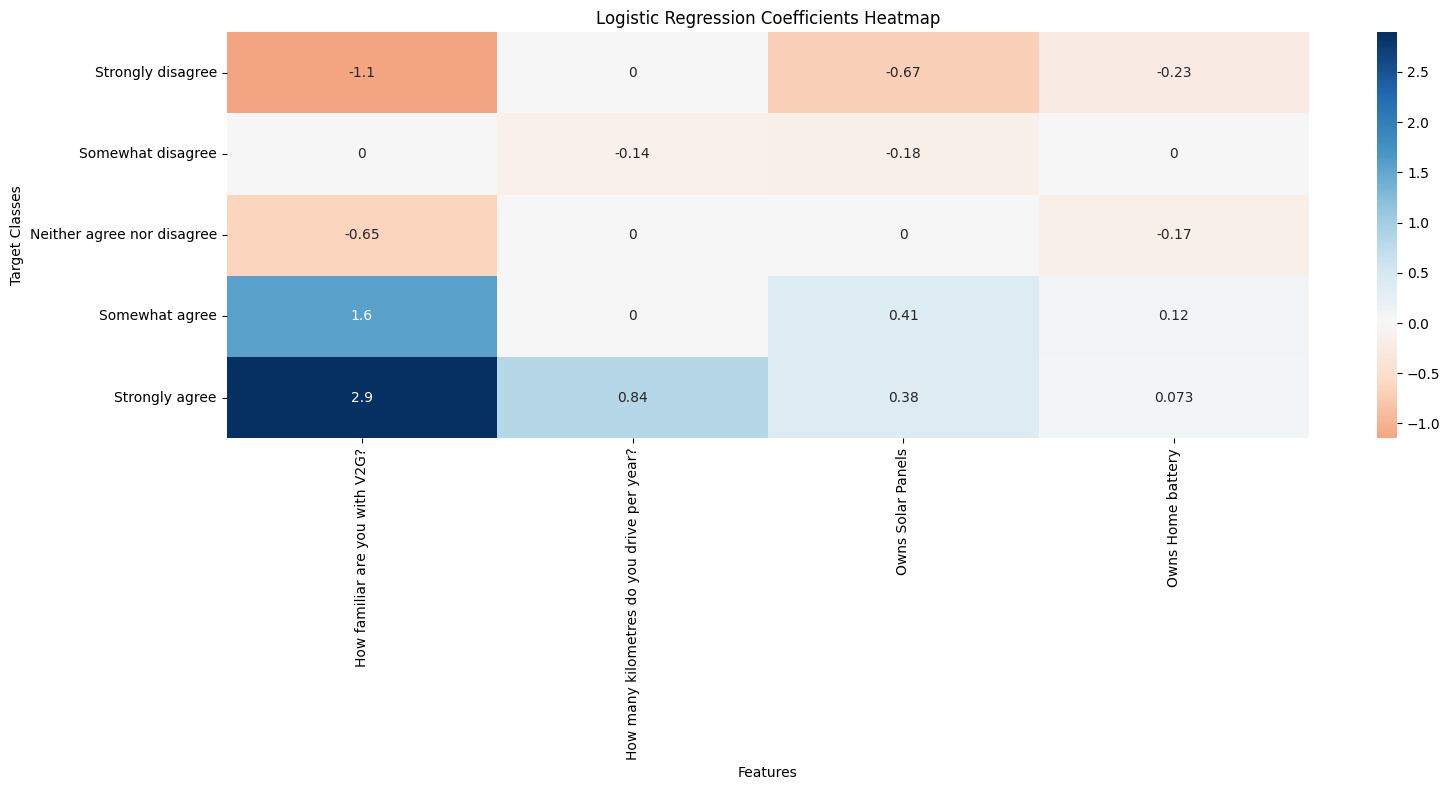

In [7]:
# Suppose 'model' is your fitted logistic regression model
coefs = model.coef_  # shape: (n_classes, n_features)

# If you want more readable row labels, use your Q10_2 category names
row_labels = q10_2_categories  # e.g., ["Strongly disagree", ..., "Strongly agree"]

# Column labels are just your feature names
col_labels = input_variables_names  # e.g., ['Q9','Q2','Q8_1','Q8_2']

plt.figure(figsize=(16, 8))
sns.heatmap(
    coefs,
    annot=True,        # display numerical values in the cells
    cmap="RdBu",     # or another diverging colormap you like
    xticklabels=col_labels,
    yticklabels=row_labels,
    center=0           # ensures 0 is in the middle of the color scale
)
plt.title("Logistic Regression Coefficients Heatmap")
plt.xlabel("Features")
plt.ylabel("Target Classes")
plt.tight_layout()
plt.show()

In [11]:
# Now let's systematically try all combinations of these variables
best_acc = 0
best_combo = None

for r in range(1, len(input_variables) + 1):
    for subset in itertools.combinations(input_variables, r):
        mean_cv_acc = evaluate_subset(csv_file, subset, target=target_variable)
        if mean_cv_acc > best_acc:
            best_acc = mean_cv_acc
            best_combo = subset

print("Best subset:", best_combo)
print("Best subset accuracy:", best_acc)

Training accuracy: 0.42341678939617083
Training accuracy: 0.34391143911439115
Training accuracy: 0.390279823269514
Training accuracy: 0.3446244477172312
Training accuracy: 0.4236162361623616
Training accuracy: 0.4329896907216495
Training accuracy: 0.422680412371134
Training accuracy: 0.388929889298893
Training accuracy: 0.36309963099631
Training accuracy: 0.3910162002945508
Training accuracy: 0.43837638376383764
Training accuracy: 0.422140221402214
Training accuracy: 0.4329896907216495
Training accuracy: 0.388929889298893
Training accuracy: 0.43837638376383764
Best subset: ('Q9', 'Q2', 'Q8_1')
Best subset accuracy: 0.43837638376383764
